In [1]:
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from soilgasflux_fcs import json_reader, models, metrics
import xarray as xr



/Users/alexnaokiasatokobayashi/opt/anaconda3/envs/Peat/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
ds = xr.open_dataset('./output/test_2024-11-20.nc')
dsMC = xr.open_dataset('./output/test_mc_2024-11-20.nc')
ds

<xarray.Dataset> Size: 14kB
Dimensions:       (time: 3, cutoff: 16, deadband: 6)
Coordinates:
  * time          (time) datetime64[ns] 24B 2024-11-20T00:20:37 ... 2024-11-2...
  * deadband      (deadband) int64 48B 0 10 20 30 40 50
  * cutoff        (cutoff) int64 128B 20 30 40 50 60 70 ... 130 140 150 160 170
Data variables:
    dcdt(HM)      (time, cutoff, deadband) float64 2kB ...
    dcdt(linear)  (time, cutoff, deadband) float64 2kB ...
    AIC(HM)       (time, cutoff, deadband) float64 2kB ...
    AIC(linear)   (time, cutoff, deadband) float64 2kB ...
    RMSE(HM)      (time, cutoff, deadband) float64 2kB ...
    RMSE(linear)  (time, cutoff, deadband) float64 2kB ...

In [15]:
dsMC

<xarray.Dataset> Size: 692kB
Dimensions:   (time: 3, cutoff: 16, deadband: 6, MC: 100)
Coordinates:
  * time      (time) datetime64[ns] 24B 2024-11-20T00:20:37 ... 2024-11-20T00...
  * deadband  (deadband) int64 48B 0 10 20 30 40 50
  * cutoff    (cutoff) int64 128B 20 30 40 50 60 70 ... 120 130 140 150 160 170
  * MC        (MC) int64 800B 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99
Data variables:
    dcdt(HM)  (time, cutoff, deadband, MC) float64 230kB ...
    AIC(HM)   (time, cutoff, deadband, MC) float64 230kB ...
    RMSE(HM)  (time, cutoff, deadband, MC) float64 230kB ...

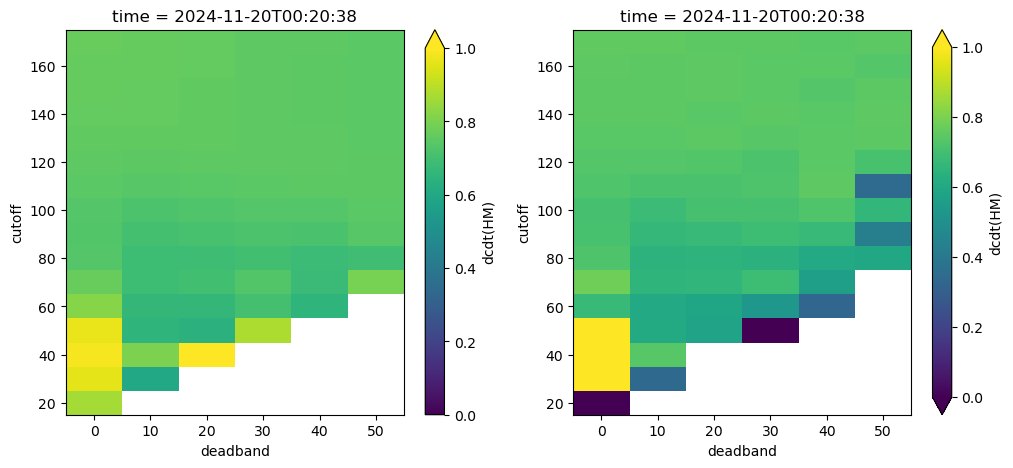

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ds.isel(time=1)['dcdt(HM)'].plot(vmin=0, vmax=1, ax=ax[0])
dsMC.isel(time=1)['dcdt(HM)'].median(dim='MC').plot(vmin=0, vmax=1, ax=ax[1])